In [1]:
%pylab inline
import numpy as np

import seaborn as sns
import glob2
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter
import natsort
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [5]:
#ls /workspace2

In [6]:
def listify_data(unique_string, path):
    glob_str = path + '*' + unique_string + '*'
    files = natsort.natsort(glob2.glob(glob_str))
    #print(glob_str)
    #return files
    
    dataList = []
    for f in files:
        with h5py.File(f,'r') as hf:
            data = hf.get('data')
            dataList.append(np.array(data))
    return dataList

In [7]:
mppoints = listify_data('midplane**', '../models/results/{}/{}/**/'.format('A', 6))

In [8]:
def get_along_strike(pts):
    dxs = np.diff(pts[:,0])
    dys = np.diff(pts[:,1])
    ds = np.sqrt(dxs**2 + dys**2)
    
    #pad the first point
    return np.append(ds[0], ds) , np.cumsum(np.append([0.], ds)) #front and back pad these arrays

In [9]:
def curvature_splines(x, y):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
    """

    fx = CubicSpline(x, x)
    fy = CubicSpline(x, y)
    #print(np.sqrt(std))

    x1 = fx.derivative(1)(x)
    x2 = fx.derivative(2)(x)
    y1 = fy.derivative(1)(x)
    y2 = fy.derivative(2)(x)
    curvature = (x1* y2 - y1* x2) / np.power(x1** 2 + y1** 2, 1.5)
    return curvature, fx, fy, y1

In [48]:
len(mppoints)

52

In [10]:
i = 48
depthlimit = 1. - (300/2900.)

In [13]:
indexes = np.argsort(mppoints[i][:,0])
sortedData = mppoints[i].copy()[indexes]
sortedData = sortedData[sortedData[:,1] > depthlimit] #sort by y
sortedData = sortedData[sortedData[:,0] > -0.5] #sort by x
#sortedData = gaussian_filter(sortedData , smoothing_0)


ds, ds_cum = get_along_strike(sortedData)
c, fx, fy, y1 = curvature_splines(sortedData[:,0], sortedData[:,1])

In [14]:
def spline_curves(x, y, s0=0,s1=0, s2=0,s3=0,dx=1.):
    c, fx, fy, y1= curvature_splines(x, gaussian_filter(y, s0))
    cx = np.gradient(gaussian_filter(c, s2), dx)
    return (gaussian_filter(y1, s1)), gaussian_filter(c, s2), gaussian_filter(cx, s3)
    

In [15]:
dxMean = 2/2900.

y1, y2, y3 = spline_curves(ds_cum, sortedData[:,1], 
                           s0=8,
                           s1=8, 
                           s2=12,
                           s3=8,
                           dx=dxMean)

In [16]:
y1_, y2_, y3_ = spline_curves(ds_cum, sortedData[:,1], 
                           s0=2,
                           s1=0, 
                           s2=0,
                           s3=2,
                           dx=dxMean)

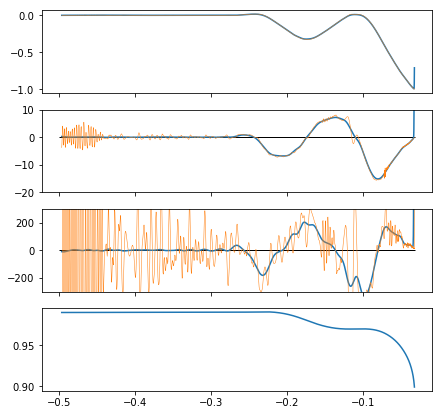

In [17]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(7, 7))
blok = 10


ax1.plot(sortedData[:,0][blok:-blok], y1[blok:-blok])
ax1.plot(sortedData[:,0][blok:-blok], y1_[blok:-blok], lw=0.5)

ax2.plot(sortedData[:,0][blok:-blok], y2[blok:-blok])
ax2.plot(sortedData[:,0][blok:-blok], y2_[blok:-blok], lw=0.5)
ax2.hlines(0., sortedData[:,0].min(), sortedData[:,0].max(), lw=1)
ax2.set_ylim(-20, 10)


ax3.plot(sortedData[:,0][blok:-blok], y3[blok:-blok])
ax3.plot(sortedData[:,0][blok:-blok], y3_[blok:-blok], lw=0.5)
ax3.hlines(0., sortedData[:,0].min(), sortedData[:,0].max(), lw=1)
ax3.set_ylim(-300, 300)


ax4.plot(sortedData[:,0][blok:-blok], sortedData[:,1][blok:-blok])

## Mesh

In [18]:
import os

import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer


In [38]:
yres = 128
xres = 768
elementType = 'Q1/dQ0'
depth = 0.3448275862068966
aspectRatio  = 5



halfWidth = 0.5*depth*aspectRatio 

minCoord_    = (-1.*halfWidth, 1. - depth) 
maxCoord_    = (halfWidth, 1.)

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = minCoord_, 
                                 maxCoord    = maxCoord_) 

scalarField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )


In [34]:
#mesh.reset() #call to reset mesh nodes to original locations
meshRefineFactor = 0.7
refineHoriz = True
refineVert = True

if refineHoriz:
    
    with mesh.deform_mesh():
        
        normXs = 2.*mesh.data[:,0]/(mesh.maxCoord[0] - mesh.minCoord[0])
        mesh.data[:,0] = mesh.data[:,0] * np.exp(meshRefineFactor*normXs**2) / np.exp(meshRefineFactor*1.0**2)    
    
if refineVert:

    with mesh.deform_mesh():
        
        mesh.data[:,1] = mesh.data[:,1] - 1.0

        normYs = -1.*mesh.data[:,1]/(mesh.maxCoord[1] - mesh.minCoord[1])
        mesh.data[:,1] = mesh.data[:,1] * np.exp(meshRefineFactor*normYs**2)/np.exp(meshRefineFactor*1.0**2)

        mesh.data[:,1] = mesh.data[:,1] + 1.0


In [77]:
sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/sigSS**.h5'))
sigFiles[i]

'/workspace2/flat_slab/A/6/sigSS_1225.h5'

In [78]:
sfile = sigFiles[i]
sfile

'/workspace2/flat_slab/A/6/sigSS_1225.h5'

In [79]:
scalarField.load(sfile)


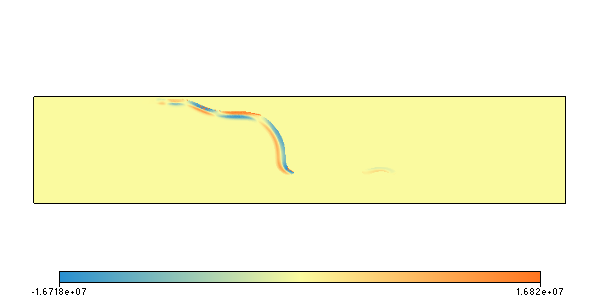

In [80]:
fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Surface(mesh, scalarField, onMesh = True))
fig.show()

In [47]:
len(sigXXFiles )

104

In [89]:
dm = 10/2900.
meshxs = np.arange(mesh.minCoord[0], mesh.maxCoord[0] , dm )
meshys = np.arange(mesh.minCoord[1], mesh.maxCoord[1] , dm )
xv, yv = np.meshgrid(0.99999999999*meshxs, meshys )
#uw just wants an Mx2 array
coords = np.array(zip(xv.flatten(), yv.flatten()))

In [90]:
stressdata = scalarField.evaluate(coords[:, :])[:,0]


In [91]:
#build array to collect the data
stress = np.zeros(xv.shape) 
stress[:] = np.flipud(stressdata.reshape((xv.shape)))*11.*1e-6

(600, 0)

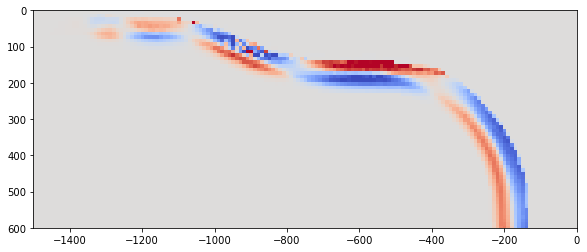

In [109]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.imshow(stress, cmap='coolwarm', vmax = 150, vmin = -150, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, (1. - mesh.minCoord[1])*2900,0])

ax.set_xlim(-1500, 0)
ax.set_ylim(600, 0)

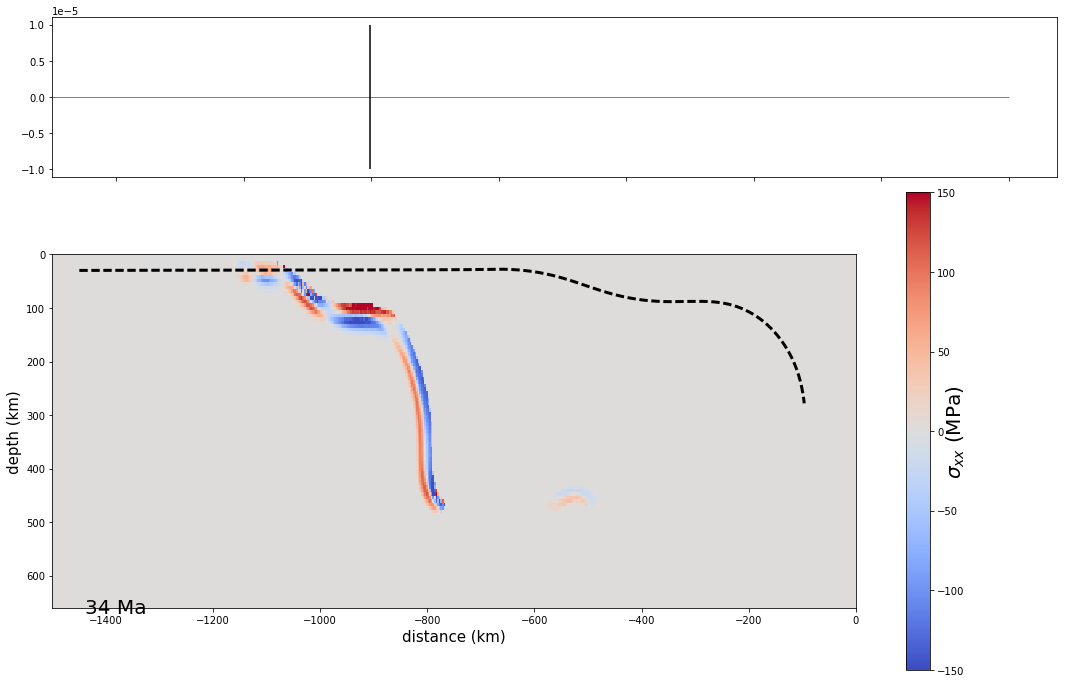

In [113]:
# plot it
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18, 12)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

########################
ax0 = plt.subplot(gs[0])

#ax0.plot(2900.*sortedData[:,0][:-30], h3[:-30]/np.abs(h3[:-30].max()) , c= 'k', ls = '--', 
#         label = r'$\frac{K_{,s}}{K_{,s_{max}}}$', lw = 2)

#r'$\frac{ \frac{\partial K}{\partial s} } {\frac{\partial K}{\partial s}_{max}} $'
#ax0.set_ylim(-0.0000407, 0.0000407)
ax0.hlines(0, -1500., 0., linewidths = 0.5)
ax0.set_xlim(-1500., 75.0)
ax0.ticklabel_format(style='sci',axis='y', scilimits=(0,0))

ax0.vlines(-1002.3507, -0.00001, 0.00001)

ax0.legend(fontsize = 20)

#ax0.set_yticklabels([])
ax0.set_xticklabels([])
#ax0.grid(False)

########################
ax1 = plt.subplot(gs[1])

cb = ax1.imshow(stress, cmap='coolwarm', vmax = 150, vmin = -150, extent=[-1500, 0,660,0])
#CS = ax1.contour(np.flipud(temp), colors='g', levels=[650., 1250.], extent=[-1500, 0,660,0])
ax1.plot(2900.*sortedData[:,0][:-30], 2900 - 2900.*sortedData[:,1][:-30], c= 'k', ls = '--', lw = 3)
#ax1.clabel(CS, fontsize=10, inline=1, fmt='%1.0f')

ax1.set_xlim(-1500,0)

ax1.set_ylabel('depth (km)', size = 15)
ax1.set_xlabel('distance (km)', size = 15)
ax1.grid(False)


h = colorbar(cb)
h.set_label(r'$\sigma_{xx}$ (MPa)', size= 20, labelpad=-20)

#h = colorbar;
#ylabel(h, 'foo')

fig.text(0.15, 0.19,'34 Ma', size = 20)